## Capteur d'accélération

Le capteur d'accélération est constitué d'une masse suspendue à un ressort avec un amortisseur.

- La force du ressort est proportionnelle à l'élongation du ressort
- La force de l'amortisseur est proportionnelle à la vitesse

In [103]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

# Données numériques du problème
Te=1e-6 # [s]
DX=0.01 # [m]
non_amorti=False

if non_amorti:
    Kf=50/DX # Rigidité du ressort
    c = 1   # Amortisseur
else:
    Kf=5/DX # Rigidité du ressort
    c = 10   # Amortisseur
    
m = 10e-3 # masse suspendue
a = 0.1   # Acceleration
T1= 0.1 # Durée de simulation

# Représentation des états
class State:
    def __init__(self,x0,v0):
        self.x = x0 # position
        self.v = v0 # vitesse
        self.a = 0  # accéleration

# Conditions initiales
X = State(0,0) # Boitier
Xm= State(0,0) # masse suspendue

# Equations du mouvement de la masse
#  On calcule l'état de la masse Xm en fonction de l'état X du boîtier
def getMassState(Xm, X):
    a = ( Kf*(X.x-Xm.x)+ c*(X.v-Xm.v))/m
    Xm.a=a
    Xm.v+=a*Te
    Xm.x+=Xm.v*Te
    return Xm

Calcul de la fréquence propre et de l'amortissement

In [104]:
w0=np.sqrt(Kf/m)
w0/(2*np.pi)

In [105]:
delta0=w0*c/2/Kf
delta0

## Definition d'une trajectoire

On définit une trajectoire uniformément accélérée.

In [106]:
def getTrajectory(X, t):
    X.a = a
    X.v += a*Te
    X.x += X.v*Te
    return X

In [107]:
timerange=np.arange(0,T1,Te)
Data=np.zeros((len(timerange),5))

index=0
for t in timerange:
    X=getTrajectory(X,t)
    Xm=getMassState(Xm,X)
    Data[index]=[X.x,X.v,Xm.x,Xm.v, Xm.a]
    index+=1

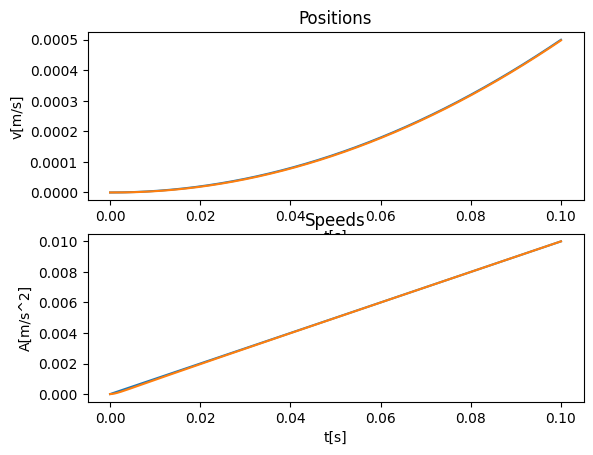

In [108]:
plt.subplot(211)
plt.plot(timerange,Data[:,[0,2]])
plt.xlabel("t[s]")
plt.ylabel("v[m/s]")
plt.title('Positions')
plt.subplot(212)
plt.plot(timerange,Data[:,[1,3]])
plt.title('Speeds')
plt.xlabel("t[s]")
plt.ylabel("A[m/s^2]")
plt.show()

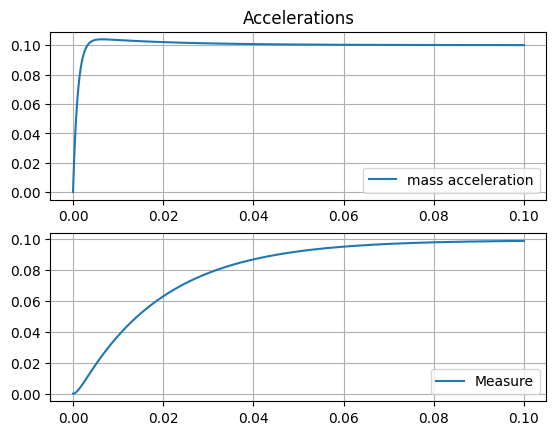

In [117]:
#| label: fig-transitory
#| fig-cap: Transitoires observés lors de l'apparition d'une accélération constante de $a=0.1[m/s^2]$
plt.subplot(211)
plt.plot(timerange,Data[:,4])
plt.legend(("mass acceleration",))
plt.grid()
plt.title("Accelerations")
plt.subplot(212)
am=(Data[:,0]-Data[:,2])*Kf/m
plt.plot(timerange,am)
plt.legend(('Measure',), loc='lower right')
plt.grid()
plt.show()

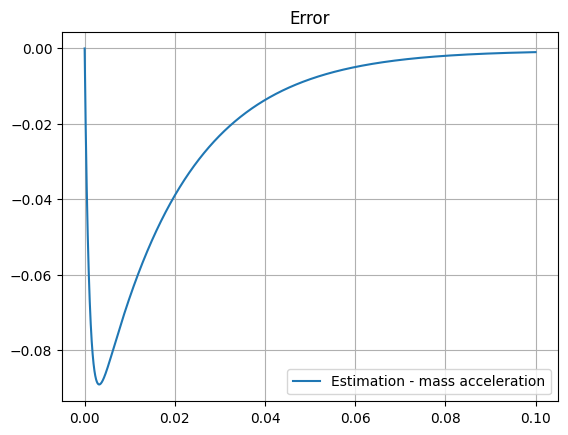

In [116]:
plt.plot(timerange, am-Data[:,4])
plt.title("Error")
plt.legend(("Estimation - mass acceleration",))
plt.grid()
plt.show()

## Réponse fréquencielle

Pour un signal sinusoïdal, on peut faire le test pour plusieurs fréquences

In [22]:
def getSinus(X,w, t):
    a = np.sin(w*t)
    X.a = a
    X.v += a*Te
    X.x += X.v*Te
    return X

In [91]:
# Conditions initiales
X = State(0,0)
Xm= State(0,0)
Te=100e-6 # [s]
timerange=np.arange(0,T1,Te)
Data=np.zeros((len(timerange),6))

fs=100
T1 = 1/fs
w=fs*2*np.pi

index=0
for t in timerange:
    X=getSinus(X,w,t)
    Xm=getMassState(Xm,X)
    Data[index]=[X.x,X.v,X.a, Xm.x,Xm.v, Xm.a]
    index+=1

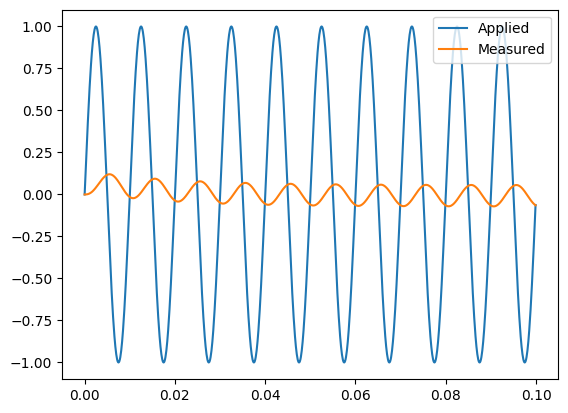

In [92]:
plt.plot(timerange, Data[:,2])
am=(Data[:,0]-Data[:,3])*Kf/m
plt.plot(timerange, am)
plt.legend(["Applied","Measured"])

## Réponse selon la fréquence

On analyse la réponse du capteur selon la fréquence du signal. On génère un signal assez long dont la fréquence augmente.

In [93]:
Te=100e-6
T1 = 10
# Plage de fréquence
w1 = 1*2*np.pi
w2 = 500/T1*2*np.pi-w1

timerange=np.arange(0,T1,Te)
Data=np.zeros((len(timerange),6))

# Fonction source
def getSweep(X,t):
    w=w1+w2*t
    a = np.sin(w*t)
    X.a = a
    X.v += a*Te
    X.x += X.v*Te
    return X

# Conditions initiales

X = State(0,0)
Xm= State(0,0)
timerange=np.arange(0,T1,Te)
Data=np.zeros((len(timerange),6))

index=0
for t in timerange:
    X=getSweep(X,t)
    Xm=getMassState(Xm,X)
    Data[index]=[X.x,X.v,X.a, Xm.x,Xm.v, Xm.a]
    index+=1

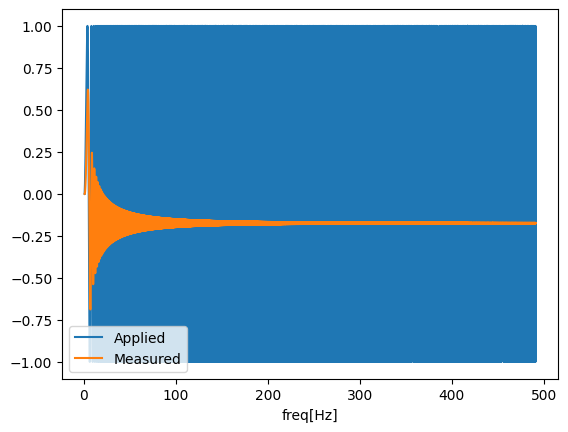

In [94]:
freqrange=(timerange*w2+w1)/(2*np.pi)
plt.plot(freqrange, Data[:,2])
am=(Data[:,0]-Data[:,3])*Kf/m
plt.plot(freqrange, am)
plt.xlabel("freq[Hz]")
plt.legend(["Applied","Measured"], loc='lower left')

## Diagramme de Bode

Ce diagramme montre la réponse en fréquence du capteur.

Il est tracé à partir de la *transformée de Laplace* qu'on déduit de l'équation dynamique du capteur.

Il *suffit* de remplacer la dérivée par un produit par un *opérateur* $s$...

In [96]:
# 
sp.init_printing()
a,s,dx,d0,omega0=sp.symbols("a,s,dx,d0,omega0")

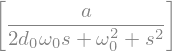

In [97]:
sol=sp.solve(sp.Eq(a,s**2*dx+2*d0*omega0*s*dx+omega0**2*dx),dx)
sol

On déduit la *fonction de transfert* de l'accéléromètre.

w0= 707.1067811865476 ,d0= 0.07071067811865475


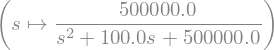

In [98]:
Kf=50/DX # Rigidité du ressort
c = 1   # Amortisseur

w0=np.sqrt(Kf/m)
delta0=w0*c/2/Kf
print("w0=",w0,",d0=",delta0)
values={d0:delta0, omega0:w0, a:w0**2}
bode=sp.Lambda(s,sol[0].subs(values))
bode

Pour obtenir un graphique, on utilise la relation $s=j2\pi f$, où $f$ est la fréquence. On obtient la réponse en amplitude du capteur pour différentes fréquences.

In [99]:
rf2=np.logspace(-1,4,100)
rs=2*np.pi*rf2*1j
rAcc=np.zeros(len(rs))
for i in range(len(rs)):
    rAcc[i]=np.abs(bode(rs[i]))

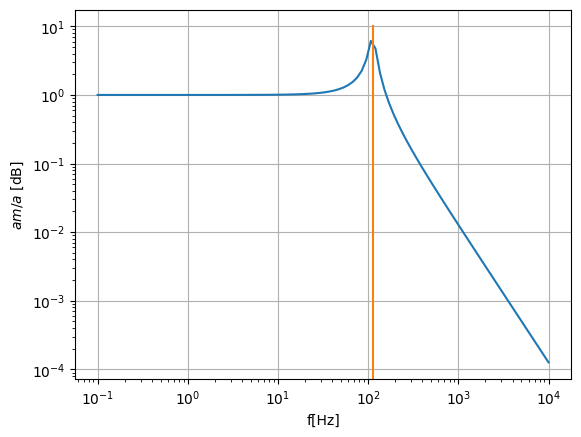

In [100]:
#| label: fig-bode-plot
#| fig-cap: Diagramme de Bode de l'accéléromètre avec une résonance indésirable.
plt.plot(rf2,(rAcc))
plt.plot(np.array([w0, w0])*(1/(2*np.pi)),[-20,10])
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.xlabel("f[Hz]")
plt.ylabel("$am/a$ [dB]")
plt.show()

In [101]:
# Avec un bon amortissement
Kf=250/DX
c=10
m= 0.001

w0=np.sqrt(Kf/m)
delta0=w0*c/2/Kf

values={d0:delta0, omega0:w0, a:w0**2}
bode=sp.Lambda(s,sol[0].subs(values))
bode

rf2=np.logspace(-1,4,100)
rs2=2*np.pi*rf2*1j
rAcc2=np.zeros(len(rs2))
for i in range(len(rs2)):
    rAcc2[i]=np.abs(bode(rs2[i]))

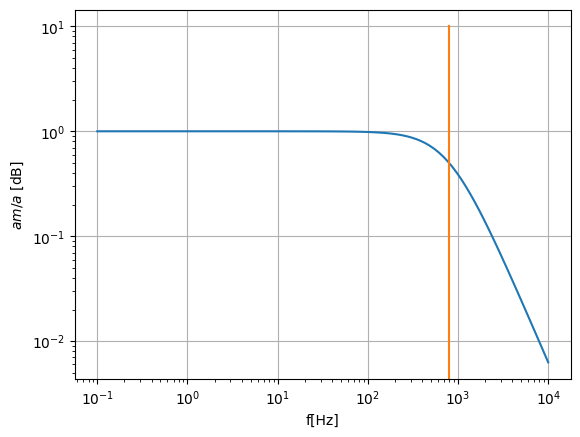

In [102]:
#| label: fig-bode-plot-amorti
#| fig-cap: Diagramme de Bode de l'accéléromètre avec un bon amortissement.
plt.plot(rf2,(rAcc2))
plt.plot(np.array([w0, w0])*(1/(2*np.pi)),[-20,10]) # fréquence de coupure
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.xlabel("f[Hz]")
plt.ylabel("$am/a$ [dB]")
plt.show()